1. Import Libraries

In [24]:
import pandas as pd
import sqlalchemy #Used for connecting to MySQL databases.
from datetime import datetime

2. Connect to MySQL 

In [25]:
username = "root"
password = "Root12345!"  
host = "localhost"
port = "3306"

#source (filedb) ==> the original data is pulled from here
#target (starschema) ==> where the transformed data will be loaded
source_engine = sqlalchemy.create_engine(f"mysql+mysqlconnector://{username}:{password}@{host}:{port}/filedb")
target_engine = sqlalchemy.create_engine(f"mysql+mysqlconnector://{username}:{password}@{host}:{port}/starschema")

3. Pulling and Transforming Data from Source Database

In [26]:
# Pull distinct payment dates from source
df_dates = pd.read_sql("""
    SELECT DISTINCT payment_date FROM payment
""", source_engine)

In [27]:
# Transforming the payment dates into a date dimension format
df_dates['full_date'] = pd.to_datetime(df_dates['payment_date'])
df_dates['year'] = df_dates['full_date'].dt.year
df_dates['month'] = df_dates['full_date'].dt.month
df_dates['day'] = df_dates['full_date'].dt.day
df_dates['day_name'] = df_dates['full_date'].dt.day_name()
df_dates['month_name'] = df_dates['full_date'].dt.month_name()
df_dates['quarter'] = df_dates['full_date'].dt.quarter

In [28]:
#Extract relevant date dimension columns and remove duplicates to prepare the dim_date dimension.
dim_date = df_dates[['full_date', 'year', 'month', 'day', 'day_name', 'month_name', 'quarter']].drop_duplicates()

4. Pull Other Dimension Tables

In [29]:
#Pulls data from the staff, rental, and payment tables from the source database to create dimensions dim_staff, dim_rental, and df_payment
df_date = pd.read_sql("SELECT * FROM dim_date", con=target_engine)

dim_staff = pd.read_sql("""
    SELECT staff_id, first_name, last_name, email, store_id FROM staff
""", source_engine)

dim_rental = pd.read_sql("""
    SELECT rental_id, rental_date, return_date, customer_id, inventory_id, staff_id FROM rental
""", source_engine)

df_payment = pd.read_sql("""
    SELECT payment_id, customer_id, staff_id, rental_id, amount, payment_date
    FROM payment
""", source_engine)

5. Join Data to Get date_id

In [30]:
# Join on dim_date to get date_id
fact_monthly_payment = df_payment.copy()
fact_monthly_payment['payment_date'] = pd.to_datetime(fact_monthly_payment['payment_date'])

fact_monthly_payment = fact_monthly_payment.merge(
    dim_date,
    left_on='payment_date',
    right_on='full_date',
    how='left'
)

In [31]:
# Drop extra columns
fact_monthly_payment = fact_monthly_payment.rename(columns={'staff_id': 'staff_id', 'rental_id': 'rental_id'})
fact_monthly_payment = fact_monthly_payment[['year', 'month', 'staff_id', 'rental_id', 'amount']]

In [32]:
dim_film = pd.read_sql("""
    SELECT film_id, title, description, release_year, language_id, rental_rate, length, rating
    FROM film
""", source_engine)

dim_store = pd.read_sql("""
    SELECT store_id, manager_staff_id, address_id FROM store
""", source_engine)

6. Prepare dim_date for Join

In [33]:
dim_date['date_id'] = pd.to_datetime(dim_date['full_date']).dt.strftime('%Y%m%d').astype(int)

7. Pull Inventory Data

In [34]:
# Pull inventory again (fresh)
df_inventory = pd.read_sql("""
    SELECT inventory_id, film_id, store_id, last_update
    FROM inventory
""", source_engine)

df_inventory['inventory_date'] = pd.to_datetime(df_inventory['last_update']).dt.date

In [37]:
# Prepare dim_date for join (convert full_date to date)
dim_date['date_only'] = pd.to_datetime(dim_date['full_date']).dt.date

8. Merge Inventory with Date

In [38]:
# Merge to get date_id
df_inventory = df_inventory.merge(
    dim_date[['date_only', 'date_id']],
    left_on='inventory_date',
    right_on='date_only',
    how='left'
)

In [39]:
fact_daily_inventory = (
    df_inventory.groupby(['date_id', 'film_id', 'store_id'])
    .agg(inventory_count=('inventory_id', 'count'))
    .reset_index()
)

9. Drop Existing Tables in Target Database

In [40]:
from sqlalchemy import text

with target_engine.connect() as conn:
    conn.execute(text("SET FOREIGN_KEY_CHECKS=0"))
    
    # Drop fact tables first (they have foreign keys to dim tables)
    conn.execute(text("DROP TABLE IF EXISTS fact_monthly_payment"))
    conn.execute(text("DROP TABLE IF EXISTS fact_daily_inventory"))

    # Now drop dimension tables
    conn.execute(text("DROP TABLE IF EXISTS dim_date"))
    conn.execute(text("DROP TABLE IF EXISTS dim_staff"))
    conn.execute(text("DROP TABLE IF EXISTS dim_rental"))
    conn.execute(text("DROP TABLE IF EXISTS dim_film"))
    conn.execute(text("DROP TABLE IF EXISTS dim_store"))
    conn.execute(text("SET FOREIGN_KEY_CHECKS=1"))
    


10. Load Data into Target Database

In [41]:
dim_date.to_sql('dim_date', con=target_engine, if_exists='replace', index=False)
dim_staff.to_sql('dim_staff', con=target_engine, if_exists='replace', index=False)
dim_rental.to_sql('dim_rental', con=target_engine, if_exists='replace', index=False)
dim_film.to_sql('dim_film', con=target_engine, if_exists='replace', index=False)
dim_store.to_sql('dim_store', con=target_engine, if_exists='replace', index=False)

fact_monthly_payment.to_sql('fact_monthly_payment', con=target_engine, if_exists='replace', index=False)
fact_daily_inventory.to_sql('fact_daily_inventory', con=target_engine, if_exists='replace', index=False)

0

11. Query and Visualize Monthly Revenue Per Staff

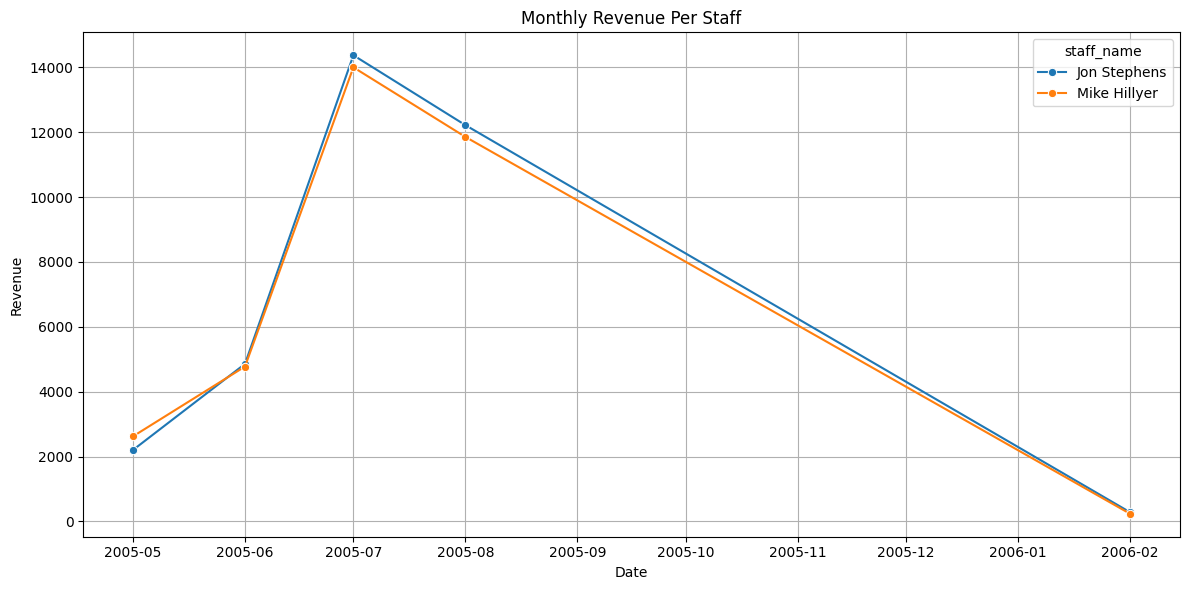

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Query monthly payment per staff
query = """
SELECT 
    fmp.year,
    fmp.month,
    CONCAT(ds.first_name, ' ', ds.last_name) AS staff_name,
    SUM(fmp.amount) AS total_amount
FROM fact_monthly_payment fmp
JOIN dim_staff ds ON fmp.staff_id = ds.staff_id
GROUP BY fmp.year, fmp.month, staff_name
ORDER BY fmp.year, fmp.month
"""

df = pd.read_sql(query, con=target_engine)

# Convert year and month to datetime
df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'].astype(str) + '-01')

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='date', y='total_amount', hue='staff_name', marker='o')
plt.title("Monthly Revenue Per Staff")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.grid(True)
plt.tight_layout()
plt.show()
